<a href="https://colab.research.google.com/github/bogazsombor/medical_research/blob/main/ClassificationBasedOnDescriptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptor-based Classification

**Sections**:
1. Data Loading Preparation and Data Analysis
2. GLM
  2.1. Baseline / Off-the-shelf Models
  2.2. From-Scratch
3. Frequency Importance Analysis
  

## I. Data Loading Preparation and Data Analysis

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


coef   = np.load("coefficients.npy")          # (50, 100, 20)
X      = coef.reshape(coef.shape[0], -1)      # (50, 2000)

labels = np.load("labels.npy")
le     = LabelEncoder()
y      = le.fit_transform(labels)             # integers 0‥4

print("Encoded class mapping:")
for code, name in enumerate(le.classes_):
    print(f"  {code} → {name}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.7
)

n_classes = len(np.unique(y))

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Encoded class mapping:
  0 → circle
  1 → elong
  2 → fold
  3 → star
  4 → tube
Train shape: (15, 2000), Test shape: (35, 2000)


## Dataset Overview

| File                | Shape          | Meaning |
|---------------------|----------------|---------|
| **`coefficients.npy`** | **(50 × 100 × 20)** | 50 objects × 100 radii × 20 FFT frequencies |
| **`labels.npy`**        | **(50,)**          | Integer class label (0–4) for each object |

### Dimension details  
* **Objects = 50** – total samples.  
* **Classes = 5** – balanced, 10 objects per class.  
* **Radii = 100** – radial positions of the descriptor.  
* **Frequencies = 20** – lowest-magnitude FFT coefficients retained.



In [ ]:
from scipy.spatial.distance import pdist, squareform
import pandas as pd

# Compute within-class distances for the training set
def within_class_distances(X, y):
    distances = []
    classes = np.unique(y)
    for c in classes:
        Xc = X[y == c]
        # All pairwise distances within this class
        dists = pdist(Xc, metric='euclidean')
        if len(dists) > 0:
            distances.append({
                "class": c,
                "mean_distance": np.mean(dists),
                "std_distance": np.std(dists),
                "min_distance": np.min(dists),
                "max_distance": np.max(dists),
                "n_samples": len(Xc)
            })
    return pd.DataFrame(distances)

df_distances = within_class_distances(X_train_scaled, y_train)
print(df_distances)


   class  mean_distance  std_distance  min_distance  max_distance  n_samples
0      0       0.000048      0.000030      0.000005      0.000071          3
1      1       0.159985      0.031710      0.125667      0.202144          3
2      2       0.071580      0.020268      0.044993      0.094150          3
3      3       0.129328      0.031814      0.084371      0.153336          3
4      4       0.137142      0.034900      0.108504      0.186273          3


In [ ]:
def inter_class_distances(X, y):
    classes = np.unique(y)
    results = []
    for i, c1 in enumerate(classes):
        X1 = X[y == c1]
        for c2 in classes[i+1:]:
            X2 = X[y == c2]
            # Compute all pairwise distances between samples in c1 and c2
            dists = np.linalg.norm(X1[:, None, :] - X2[None, :, :], axis=2).flatten()
            results.append({
                "class_1": c1,
                "class_2": c2,
                "mean_distance": np.mean(dists),
                "std_distance": np.std(dists),
                "min_distance": np.min(dists),
                "max_distance": np.max(dists),
                "n_pairs": len(dists)
            })
    return pd.DataFrame(results)

df_inter_distances = inter_class_distances(X_train_scaled, y_train)
print(df_inter_distances)


   class_1  class_2  mean_distance  std_distance  min_distance  max_distance  \
0        0        1       5.077356      0.007818      5.071422      5.088402   
1        0        2       1.750677      0.009006      1.743283      1.763356   
2        0        3       2.989484      0.020200      2.960986      3.005472   
3        0        4       0.286585      0.009178      0.278163      0.299352   
4        1        2       3.864130      0.014097      3.845301      3.885156   
5        1        3       3.689465      0.019529      3.660195      3.725906   
6        1        4       4.916482      0.009255      4.906786      4.935088   
7        2        3       1.697807      0.012393      1.678276      1.711809   
8        2        4       1.559544      0.010420      1.546897      1.579830   
9        3        4       2.824049      0.021654      2.789009      2.851918   

   n_pairs  
0        9  
1        9  
2        9  
3        9  
4        9  
5        9  
6        9  
7        9  
8 

## II.1 Baseline / Off-the-shelf Models


In [ ]:
#  Candidate models
from sklearn.linear_model import (
    LogisticRegression, PoissonRegressor,
    GammaRegressor, TweedieRegressor
)
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time, warnings

warnings.filterwarnings("ignore", category=FutureWarning)

models = {
    # GLM – canonical logit
    "LogReg_newton-cg" : LogisticRegression(
                            multi_class="multinomial",
                            solver="newton-cg",
                            max_iter=400,
                            n_jobs=-1,
                            tol=1e-6),

    # GLM regressors – canonical log link
    "PoissonRegressor" : PoissonRegressor(alpha=0.0, max_iter=1000),
    "GammaRegressor"   : GammaRegressor(alpha=0.0, max_iter=1000),
    "TweedieReg_p1.5"  : TweedieRegressor(power=1.5, alpha=0.0, max_iter=1000),

    # Linear and tree baselines
    "LinearSVC"        : make_pipeline(
                            StandardScaler(with_mean=False),
                            LinearSVC(dual=False, max_iter=5000)),
    "RandomForest"     : RandomForestClassifier(
                            n_estimators=400, max_depth=None, n_jobs=-1,
                            min_samples_leaf=1, random_state=42),
}

# Train + evaluate
results = []

for name, mdl in models.items():
    try:
        t0 = time.time()

        if name in ("GammaRegressor", "TweedieReg_p1.5"):
            mdl.fit(X_train_scaled, y_train + 1)                # need strictly positive y
            raw_pred = mdl.predict(X_test_scaled) - 1
        else:
            mdl.fit(X_train_scaled, y_train)
            raw_pred = mdl.predict(X_test_scaled)

        if raw_pred.ndim == 1:                   # regressors
            y_pred = np.clip(np.rint(raw_pred), 0, n_classes-1).astype(int)
        else:                                    # classifier already returns labels
            y_pred = raw_pred

        acc      = accuracy_score(y_test, y_pred)
        fit_time = time.time() - t0
        results.append((name, acc, fit_time, "ok"))

    except Exception as e:
        results.append((name, None, None, f"FAILED: {e.__class__.__name__}"))



for name, mdl in models.items():
    if name == "LogReg_newton-cg":
        clf = mdl

# Leaderboard
print("\nTest-set accuracy")
print("──────────────────")
for name, acc, t, note in sorted(results, key=lambda z: (acc is None, -(acc or 0))):
    if acc is not None:
        print(f"{name:18s} : {acc*100:6.2f}%   (fit {t:4.2f} s)")
    else:
        print(f"{name:18s} : {note}")



Test-set accuracy
──────────────────
LogReg_newton-cg   :  80.00%   (fit 1.55 s)
PoissonRegressor   :  40.00%   (fit 0.06 s)
GammaRegressor     :  77.50%   (fit 0.02 s)
TweedieReg_p1.5    :  90.00%   (fit 0.03 s)
LinearSVC          : 100.00%   (fit 0.03 s)
RandomForest       : 100.00%   (fit 0.80 s)


## II.2 From scratch


## 1. Newton’s method for one variable

Newton’s method finds a root or minimum of a smooth function by using its first and second derivatives. Starting from an initial guess $$x_0$$, each step replaces the function with its second-order Taylor approximation around $$x_k$$. The update

$$
x_{k+1} = x_k - \frac{g'(x_k)}{g''(x_k)}
$$

moves you toward the optimum, and you stop when the gradient or the change in $$x$$ is tiny.

## 2. Extending to multiple variables

In higher dimensions you swap the ordinary derivative for the gradient $$\nabla g(\mathbf x)$$ and the second derivative for the Hessian $$H(\mathbf x)$$, a matrix of second partials. The ideal Newton step solves

$$
H(\mathbf x_k)\,\delta = \nabla g(\mathbf x_k)
$$

and then updates

$$
\mathbf x_{k+1} = \mathbf x_k - H(\mathbf x_k)^{-1}\,\nabla g(\mathbf x_k).
$$

In practice you wrap this in a line search (e.g.\ Armijo) to pick a safe step size, and you stop once the gradient norm or the step length falls below a threshold.

## 3. Newton–CG

Forming and inverting the full Hessian becomes impossible when the dimension is large. Newton–CG sidesteps that by solving

$$
H(\mathbf x_k)\,\delta = \nabla g(\mathbf x_k)
$$

iteratively with Conjugate Gradient: you only need to compute $$H\,v$$ products rather than store $$H$$. By running just a few CG iterations (“inexact Newton”), you keep most of Newton’s fast convergence while slashing memory and compute costs—ideal for very large problems.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import trange

# --- Helper: compute class probabilities (baseline = last class)
def softmax_prob(X, B, clip=50.0):
    S = np.clip(X @ B, -clip, clip)          # (n, K-1)
    eS = np.exp(S)
    denom = 1.0 + eS.sum(1, keepdims=True)
    return np.hstack([eS / denom, 1.0 / denom])   # (n, K)

def multinomial_newton_numpy_debug(
        X, y, X_val=None, y_val=None,
        *, lam=1e-4, max_iter=30,
        tol_grad=1e-4, tol_step=1e-6,
        clip=50.0, verbose=True, eig_threshold=4000,
        print_every=1):
    """
    Multinomial (baseline class) logistic regression with Newton's method
    """
    # Add bias column
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    n, p = Xb.shape

    classes = np.unique(y)
    K = len(classes)
    Y = np.eye(K)[y]                      # (n, K)

    # Validation design matrix
    if X_val is not None:
        Xv = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

    eps = 1e-12
    I_p = np.eye(p); I_p[0, 0] = 0.0      # no reg on bias
    B = np.zeros((p, K-1))                # parameters (baseline omitted)

    def reg_ll(P, B):
        return np.sum(Y * np.log(P + eps)) - 0.5 * lam * np.sum(B[1:]**2)

    for it in trange(max_iter, desc="Newton"):
        # Forward + gradient
        P = softmax_prob(Xb, B, clip)
        G = Xb.T @ (Y[:, :K-1] - P[:, :K-1]) - lam * (I_p @ B)
        gnorm = np.linalg.norm(G)

        if verbose and it % print_every == 0:
            ll = reg_ll(P, B)
            print(f"\n=== Iter {it:02d} ===")
            print(f"  log-likelihood  : {ll: .6e}")
            print(f"  ||grad||_F      : {gnorm: .3e}")
            print(f"  max|grad|       : {np.abs(G).max(): .3e}")
            print(f"  P.min / P.max   : {P.min():.3e} / {P.max():.3e}")

        if gnorm < tol_grad:
            if verbose: print("Converged (gradient norm).")
            break

        # Hessian blocks
        H = np.zeros((p*(K-1), p*(K-1)))
        for j in range(K-1):
            for k in range(K-1):
                if j == k:
                    w = P[:, j]*(1 - P[:, j])
                    block = (Xb.T * w) @ Xb + lam*I_p
                else:
                    w = -P[:, j]*P[:, k]
                    block = (Xb.T * w) @ Xb
                H[j*p:(j+1)*p, k*p:(k+1)*p] = block

        if verbose and it % print_every == 0:
            if H.shape[0] <= eig_threshold:
                eigs = np.linalg.eigvalsh(H)
                print(f"  Hess eig min/max: {eigs.min(): .3e} / {eigs.max(): .3e}")
            else:
                diagH = np.diag(H)
                print(f"  Hess diag min/max: {diagH.min(): .3e} / {diagH.max(): .3e}")

        # Newton direction
        try:
            delta_vec = np.linalg.solve(H, G.ravel(order='F'))
        except np.linalg.LinAlgError as e:
            raise RuntimeError(f"Hessian singular / not SPD: {e}")
        delta = delta_vec.reshape(B.shape, order='F')

        # Armijo line search
        step = 1.0
        ll0 = reg_ll(P, B)
        n_ls = 0
        while step > 1e-6:
            B_try = B + step * delta
            P_try = softmax_prob(Xb, B_try, clip)
            if reg_ll(P_try, B_try) > ll0 + 1e-12:  # sufficient ascent
                B = B_try
                break
            step *= 0.5
            n_ls += 1

        if verbose and it % print_every == 0:
            print(f"  step accepted  : {step:.3e} (backtracks: {n_ls})")
            print(f"  ||step*delta|| : {np.linalg.norm(step*delta):.3e}")
            if X_val is not None:
                Pv = softmax_prob(Xv, B, clip)
                acc_val = accuracy_score(y_val, Pv.argmax(1))*100
                print(f"  val accuracy   : {acc_val: .2f} %")

        # Optional step-size based stopping
        if np.linalg.norm(step*delta) < tol_step:
            if verbose: print("Converged (step size).")
            break

    return B, classes


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
import numpy as np

def multinomial_predict(X, beta, clip=50.0):
    """Predict classes and probabilities. X already scaled. Adds bias column internally."""
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    P  = softmax_prob(Xb, beta, clip=clip)
    return P.argmax(axis=1), P

# Fit (no scaler returned; third value is placeholder)
B, classes = multinomial_newton_numpy_debug(
    X_train_scaled, y_train,
    X_val=X_test_scaled, y_val=y_test,
    lam=1e-4, max_iter=1, verbose=True
)

# Predict
y_pred, P_test = multinomial_predict(X_test_scaled, B)

# Metrics
acc = accuracy_score(y_test, y_pred)
nll = log_loss(y_test, P_test, labels=classes)

print(f"Accuracy     : {acc*100:.2f}%")
print(f"Neg. Log-Loss: {nll:.4f}")
print("beta shape   :", B.shape)


Newton:   0%|          | 0/1 [00:00<?, ?it/s]


=== Iter 00 ===
  log-likelihood  : -2.414157e+01
  ||grad||_F      :  1.272e+01
  max|grad|       :  1.849e+00
  P.min / P.max   : 2.000e-01 / 2.000e-01
  Hess diag min/max:  1.004e-04 /  2.400e+00


Newton: 100%|██████████| 1/1 [00:12<00:00, 12.38s/it]

  step accepted  : 1.000e+00 (backtracks: 0)
  ||step*delta|| : 9.535e+01
  val accuracy   :  100.00 %
Accuracy     : 100.00%
Neg. Log-Loss: 0.0304
beta shape   : (2001, 4)


### 2. Newton-Rapson, Fisher-scoring, IRLS

## Data preparation and parameterization

We reshape each input into a matrix $X\in\mathbb{R}^{n\times(p-1)}$, then prepend a column of ones so that  
$$
X_b = [\mathbf{1},\,X]\;\in\;\mathbb{R}^{n\times p}.
$$  
Labels $y\in\{0,\dots,K-1\}^n$ are one-hot encoded into $Y\in\{0,1\}^{n\times K}$.  We reserve class $K-1$ as the reference with coefficient vector zero, and learn  
$$
B \in \mathbb{R}^{p\times(K-1)},
$$  
initialized to zero.  A ridge penalty of strength $\lambda$ applies to all rows of $B$ except the intercept (first row).

## Softmax probabilities and penalized log-likelihood

Raw scores are  
$$
S = X_b\,B,\qquad S\leftarrow \mathrm{clip}(S,\,-c,\,c)
$$  
to avoid overflow.  The softmax probabilities for $j=0,\dots,K-1$ are  
$$
P_{ij} =
\begin{cases}
\dfrac{e^{S_{i,j}}}{1 + \sum_{m=0}^{K-2} e^{S_{i,m}}}, & j=0,\dots,K-2,\\[8pt]
\dfrac{1}{1 + \sum_{m=0}^{K-2} e^{S_{i,m}}}, & j = K-1.
\end{cases}
$$  
With a small $varepsilon$ inside the log, the penalized log-likelihood is  
$$
\ell(B)
= \sum_{i=1}^n\sum_{j=0}^{K-1} Y_{ij}\,\log(P_{ij} + \varepsilon)
\;-\;\frac{\lambda}{2}\sum_{r=2}^p\sum_{s=1}^{K-1} B_{r,s}^2.
$$

## Gradient and second-order updates

The gradient (common to all methods) is  
$$
\nabla\ell(B)
= X_b^\top\bigl(Y_{:,0:K-1} - P_{:,0:K-1}\bigr)
\;-\;\lambda
\begin{pmatrix}
0 \\[3pt]
B_{2:p,*}
\end{pmatrix}.
$$

### Newton–Raphson  
Build the **observed** Hessian  
$$
H \;=\; -\sum_{i=1}^n\;x_i x_i^\top \;\otimes\;\bigl[\mathrm{Diag}(p_i)-p_i p_i^\top\bigr]
\;-\;\lambda\,I,
$$  
where $p_i\in\mathbb{R}^{K-1}$ are the non-baseline probabilities for sample $i$.  Solve  
$$
H\,\mathrm{vec}(\Delta) = \mathrm{vec}\bigl(\nabla\ell(B)\bigr),
\qquad
B\leftarrow B + \Delta.
$$

### Fisher scoring  
Replace each $\mathrm{Diag}(p_i)-p_i p_i^\top$ by its expectation (same form for softmax), add $\lambda I$, then solve  
$$
I\,\mathrm{vec}(\Delta) = \mathrm{vec}\bigl(\nabla\ell(B)\bigr).
$$

### IRLS  
Accumulate the weighted-least-squares matrix  
$$
M = \sum_{i=1}^n x_i x_i^\top \otimes\bigl[\mathrm{Diag}(p_i)-p_i p_i^\top\bigr]
\;+\;\lambda\,I,
$$  
then solve  
$$
M\,\mathrm{vec}(\Delta)=\mathrm{vec}(\nabla\ell(B)).
$$

## Convergence and prediction

We stop when either  
$$
\|\nabla\ell(B)\|_F < \varepsilon
\quad\text{or}\quad
\|\Delta\|_F < \varepsilon.
$$  
On a validation set $X_{\text{val}}$, predicted classes are  
$$
\hat y = \arg\max_j P\bigl(y=j\mid X_{\text{val}}\bigr).
$$


In [ ]:
import numpy as np
from tqdm import trange
from sklearn.metrics import accuracy_score


def multinomial_logistic_regression(
    X, y, *,
    method="newton",            # 'newton' | 'fisher' | 'irls'
    X_val=None, y_val=None,     # optional validation set
    lam=1e-4,                   # ridge (L2) strength
    max_iter=50,
    tol_grad=1e-6,
    tol_step=1e-8,
    clip=50.0,
    eps=1e-12,
    verbose=True,
    print_every=1,
    flatten=True
):
    """
    Multinomial logistic regression with three distinct second-order methods:
      - newton : observed Hessian (Newton-Raphson)
      - fisher : Fisher scoring (expected information)
      - irls   : IRLS (working response + weighted GLS form)
    Parameterization: last class is the reference (K-1 logits).
    """

    # Data prep
    if flatten:
        X = X.reshape(X.shape[0], -1)
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])  # shape (n, p)
    n, p = Xb.shape

    classes, y_idx = np.unique(y, return_inverse=True)
    K = len(classes)
    if K < 2:
        return np.zeros((p, 0)), classes

    Y = np.eye(K)[y_idx]          # (n, K)
    B = np.zeros((p, K-1))        # parameter matrix
    I_p = np.eye(p); I_p[0, 0] = 0  # do not penalize intercept

    if X_val is not None:
        if flatten:
            X_val = X_val.reshape(X_val.shape[0], -1)
        Xv = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

    def prob(Xm, Bm):
        S  = np.clip(Xm @ Bm, -clip, clip)     # (n, K-1)
        eS = np.exp(S)
        denom = 1.0 + eS.sum(1, keepdims=True)
        return np.hstack([eS / denom, 1.0 / denom])  # (n, K)

    def loglik(Pm, Bm):
        # Penalized log-likelihood
        return (Y * np.log(Pm + eps)).sum() - 0.5 * lam * np.sum(Bm[1:]**2)

    iterator = trange(max_iter, desc=method.upper()) if verbose else range(max_iter)

    for it in iterator:
        P = prob(Xb, B)  # (n, K)

        # Gradient (common)
        # g_j = X^T (Y_j - P_j) - lam * B_j  for j=1..K-1
        G = Xb.T @ (Y[:, :K-1] - P[:, :K-1]) - lam * (I_p @ B)  # (p, K-1)
        gnorm = np.linalg.norm(G)
        if gnorm < tol_grad:
            if verbose:
                iterator.write(f"Stop (grad) iter={it} ||g||={gnorm:.2e}")
            break

        if method == "newton":
            # Observed Hessian (second derivative of penalized loglik)
            # H = - sum_i ( (x_i x_i^T) kron Var_i ), Var_i = diag(p_i*) - p_i* p_i*^T
            H = np.zeros((p*(K-1), p*(K-1)))
            for i in range(n):
                pi = P[i, :K-1]                       # (K-1,)
                Vi = np.diag(pi) - np.outer(pi, pi)   # (K-1, K-1)
                x_i = Xb[i:i+1, :].T                  # (p,1)
                XiXiT = x_i @ x_i.T                   # (p,p)
                for j in range(K-1):
                    for k in range(K-1):
                        blk = Vi[j, k] * XiXiT
                        H[j*p:(j+1)*p, k*p:(k+1)*p] -= blk
            # Ridge Hessian part: -lam * I (no penalty on intercept row)
            for j in range(K-1):
                H[j*p:(j+1)*p, j*p:(j+1)*p] -= lam * I_p
            delta = -np.linalg.solve(H, G.ravel(order="F")).reshape(B.shape, order="F")

        elif method == "fisher":
            # Fisher scoring (expected information)
            I = np.zeros((p*(K-1), p*(K-1)))
            for i in range(n):
                pi_full = P[i, :]
                Vi_full = np.diag(pi_full) - np.outer(pi_full, pi_full)
                Vi = Vi_full[:K-1, :K-1]
                x_i = Xb[i:i+1, :].T
                XiXiT = x_i @ x_i.T
                for j in range(K-1):
                    for k in range(K-1):
                        I[j*p:(j+1)*p, k*p:(k+1)*p] += Vi[j, k] * XiXiT
            # Add ridge on LHS: + lam * I
            for j in range(K-1):
                I[j*p:(j+1)*p, j*p:(j+1)*p] += lam * I_p
            delta = np.linalg.solve(I, G.ravel(order="F")).reshape(B.shape, order="F")

        elif method == "irls":
            # IRLS: conceptually build weighted least squares system
            # Same linear system as Fisher but kept separate for clarity
            Wmat = np.zeros((p*(K-1), p*(K-1)))
            for i in range(n):
                pi_full = P[i, :]
                Vi_full = np.diag(pi_full) - np.outer(pi_full, pi_full)
                Vi = Vi_full[:K-1, :K-1]
                x_i = Xb[i:i+1, :].T
                XiXiT = x_i @ x_i.T
                for j in range(K-1):
                    for k in range(K-1):
                        Wmat[j*p:(j+1)*p, k*p:(k+1)*p] += Vi[j, k] * XiXiT
            for j in range(K-1):
                Wmat[j*p:(j+1)*p, j*p:(j+1)*p] += lam * I_p
            delta = np.linalg.solve(Wmat, G.ravel(order="F")).reshape(B.shape, order="F")

        else:
            raise ValueError("method must be one of {'newton','fisher','irls'}")

        step_norm = np.linalg.norm(delta)
        B += delta

        if verbose and (it % print_every == 0):
            ll_prev = loglik(P, B - delta)  # loglik before update
            msg = (f"\nIter {it:02d} | logL={ll_prev:.6e} "
                   f"| ||grad||={gnorm:.3e} | ||Delta||={step_norm:.3e}")
            if X_val is not None:
                Pv = prob(Xv, B)
                acc = accuracy_score(y_val, Pv.argmax(1)) * 100
                msg += f" | val-acc={acc:5.2f}%"
            iterator.write(msg)

        if step_norm < tol_step:
            if verbose:
                iterator.write(f"Stop (step) iter={it} ||Delta||={step_norm:.2e}")
            break

    return B, classes


def multinomial_predict(X, B, classes, clip=50.0):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    S  = np.clip(Xb @ B, -clip, clip)
    eS = np.exp(S)
    denom = 1.0 + eS.sum(1, keepdims=True)
    P  = np.hstack([eS / denom, 1.0 / denom])
    return classes[P.argmax(1)], P


In [ ]:
B_newton, classes = multinomial_logistic_regression(
    X_train_scaled, y_train,
    method="newton",       # 'newton', 'fisher', 'irls'
    X_val=X_test_scaled, y_val=y_test,
    lam= 1e-4,
    max_iter=10,
    verbose=True,
    print_every=1
)

y_pred, P_test = multinomial_predict(X_test_scaled, B_newton, classes)

from sklearn.metrics import accuracy_score, log_loss
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test NLL     :", log_loss(y_test, P_test, labels=classes))

'''
Convergence with 0 regularization
EWTON:  10%|█         | 1/10 [00:16<02:29, 16.65s/it]
Iter 00 | logL=-2.414157e+01 | ||grad||=1.272e+01 | ||Delta||=6.813e+09 | val-acc=25.71%
NEWTON:  20%|██        | 2/10 [00:32<02:11, 16.47s/it]
Iter 01 | logL=-3.989248e-01 | ||grad||=4.173e-01 | ||Delta||=5.736e+07 | val-acc=25.71%
NEWTON:  30%|███       | 3/10 [00:54<02:10, 18.69s/it]
Iter 02 | logL=-1.440761e-01 | ||grad||=1.520e-01 | ||Delta||=1.847e+08 | val-acc=25.71%
NEWTON:  40%|████      | 4/10 [01:10<01:45, 17.57s/it]
Iter 03 | logL=-5.265394e-02 | ||grad||=5.572e-02 | ||Delta||=8.165e+06 | val-acc=25.71%
NEWTON:  50%|█████     | 5/10 [01:27<01:26, 17.40s/it]
Iter 04 | logL=-1.932377e-02 | ||grad||=2.047e-02 | ||Delta||=1.988e+07 | val-acc=25.71%
NEWTON:  60%|██████    | 6/10 [01:44<01:08, 17.22s/it]
Iter 05 | logL=-7.102554e-03 | ||grad||=7.528e-03 | ||Delta||=3.236e+07 | val-acc=25.71%
NEWTON:  70%|███████   | 7/10 [02:00<00:50, 16.83s/it]
Iter 06 | logL=-2.612037e-03 | ||grad||=2.769e-03 | ||Delta||=2.497e+07 | val-acc=25.71%
NEWTON:  80%|████████  | 8/10 [02:17<00:33, 16.87s/it]
Iter 07 | logL=-9.608004e-04 | ||grad||=1.019e-03 | ||Delta||=1.278e+07 | val-acc=25.71%
NEWTON:  90%|█████████ | 9/10 [02:33<00:16, 16.80s/it]
Iter 08 | logL=-3.534432e-04 | ||grad||=3.747e-04 | ||Delta||=5.463e+07 | val-acc=25.71%
NEWTON: 100%|██████████| 10/10 [02:50<00:00, 17.02s/it]
Iter 09 | logL=-1.300224e-04 | ||grad||=1.378e-04 | ||Delta||=5.659e+08 | val-acc=22.86%
Test accuracy: 0.22857142857142856
Test NLL     : 18.79606689674017
'''

NEWTON:  10%|█         | 1/10 [00:22<03:19, 22.14s/it]


Iter 00 | logL=-2.414157e+01 | ||grad||=1.272e+01 | ||Delta||=9.535e+01 | val-acc=100.00%


NEWTON:  20%|██        | 2/10 [00:38<02:30, 18.84s/it]


Iter 01 | logL=-6.576384e-01 | ||grad||=4.465e-01 | ||Delta||=3.778e+01 | val-acc=100.00%


NEWTON:  30%|███       | 3/10 [00:54<02:03, 17.65s/it]


Iter 02 | logL=-3.858559e-01 | ||grad||=4.347e-01 | ||Delta||=2.352e+01 | val-acc=100.00%


NEWTON:  40%|████      | 4/10 [01:11<01:44, 17.37s/it]


Iter 03 | logL=-2.638249e-01 | ||grad||=1.728e-01 | ||Delta||=3.452e+01 | val-acc=100.00%


NEWTON:  50%|█████     | 5/10 [01:29<01:26, 17.38s/it]


Iter 04 | logL=-2.041358e-01 | ||grad||=4.336e-02 | ||Delta||=2.703e+01 | val-acc=100.00%


NEWTON:  60%|██████    | 6/10 [01:45<01:08, 17.08s/it]


Iter 05 | logL=-1.828758e-01 | ||grad||=1.416e-02 | ||Delta||=2.680e+01 | val-acc=100.00%


NEWTON:  70%|███████   | 7/10 [02:02<00:51, 17.13s/it]


Iter 06 | logL=-1.733167e-01 | ||grad||=8.851e-03 | ||Delta||=8.372e+01 | val-acc=100.00%


NEWTON:  80%|████████  | 8/10 [02:19<00:33, 16.95s/it]


Iter 07 | logL=-1.430755e-01 | ||grad||=5.027e-03 | ||Delta||=8.250e+01 | val-acc=100.00%


NEWTON:  90%|█████████ | 9/10 [02:36<00:16, 16.82s/it]


Iter 08 | logL=-1.252802e-01 | ||grad||=1.897e-03 | ||Delta||=1.057e+01 | val-acc=100.00%


NEWTON: 100%|██████████| 10/10 [02:52<00:00, 17.25s/it]


Iter 09 | logL=-1.240234e-01 | ||grad||=7.694e-04 | ||Delta||=4.893e+00 | val-acc=100.00%
Test accuracy: 1.0
Test NLL     : 0.0024307746840001886


'\nConvergence with 0 regularization\nEWTON:  10%|█         | 1/10 [00:16<02:29, 16.65s/it]\nIter 00 | logL=-2.414157e+01 | ||grad||=1.272e+01 | ||Delta||=6.813e+09 | val-acc=25.71%\nNEWTON:  20%|██        | 2/10 [00:32<02:11, 16.47s/it]\nIter 01 | logL=-3.989248e-01 | ||grad||=4.173e-01 | ||Delta||=5.736e+07 | val-acc=25.71%\nNEWTON:  30%|███       | 3/10 [00:54<02:10, 18.69s/it]\nIter 02 | logL=-1.440761e-01 | ||grad||=1.520e-01 | ||Delta||=1.847e+08 | val-acc=25.71%\nNEWTON:  40%|████      | 4/10 [01:10<01:45, 17.57s/it]\nIter 03 | logL=-5.265394e-02 | ||grad||=5.572e-02 | ||Delta||=8.165e+06 | val-acc=25.71%\nNEWTON:  50%|█████     | 5/10 [01:27<01:26, 17.40s/it]\nIter 04 | logL=-1.932377e-02 | ||grad||=2.047e-02 | ||Delta||=1.988e+07 | val-acc=25.71%\nNEWTON:  60%|██████    | 6/10 [01:44<01:08, 17.22s/it]\nIter 05 | logL=-7.102554e-03 | ||grad||=7.528e-03 | ||Delta||=3.236e+07 | val-acc=25.71%\nNEWTON:  70%|███████   | 7/10 [02:00<00:50, 16.83s/it]\nIter 06 | logL=-2.612037e-03 | 

## III. Frequency Importance Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# parameters
classes   = le.classes_                # pull the true class‐order
n_classes = len(classes)
n_positions = 100
n_freqs     = 20

# reshape coefficients into (n_classes, positions, freqs)
coefs = clf.coef_.reshape(n_classes, n_positions, n_freqs)

# mean abs‐coef across freqs -> importance per position
pos_importance = np.abs(coefs).mean(axis=2)   # shape (n_classes, n_positions)

# mean abs‐coef across positions -> importance per frequency
freq_importance = np.abs(coefs).mean(axis=1)  # shape (n_classes, n_freqs)

# plot both heatmaps side by side
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))

# — heatmap by position —
im0 = ax0.imshow(pos_importance, aspect='auto', cmap='coolwarm')
ax0.set_title("Importance by Position\n(mean over freqs)")
ax0.set_ylabel("Class")
ax0.set_xlabel("Position")
ax0.set_yticks(np.arange(n_classes))
ax0.set_yticklabels(classes)
ax0.set_xticks(np.arange(0, n_positions, 10))
ax0.set_xticklabels([f"Pos {i}" for i in range(0, n_positions, 10)])
fig.colorbar(im0, ax=ax0, label="|Coef|")

# — heatmap by frequency —
im1 = ax1.imshow(freq_importance, aspect='auto', cmap='coolwarm')
ax1.set_title("Importance by Frequency\n(mean over positions)")
ax1.set_ylabel("Class")
ax1.set_xlabel("Frequency")
ax1.set_yticks(np.arange(n_classes))
ax1.set_yticklabels(classes)
ax1.set_xticks(np.arange(0, n_freqs, 5))
ax1.set_xticklabels([f"Freq {i}" for i in range(0, n_freqs, 5)])
fig.colorbar(im1, ax=ax1, label="|Coef|")

plt.tight_layout()
plt.show()


NameError: name 'clf' is not defined

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Test accuracy (with specified removals): 0.7894736842105263


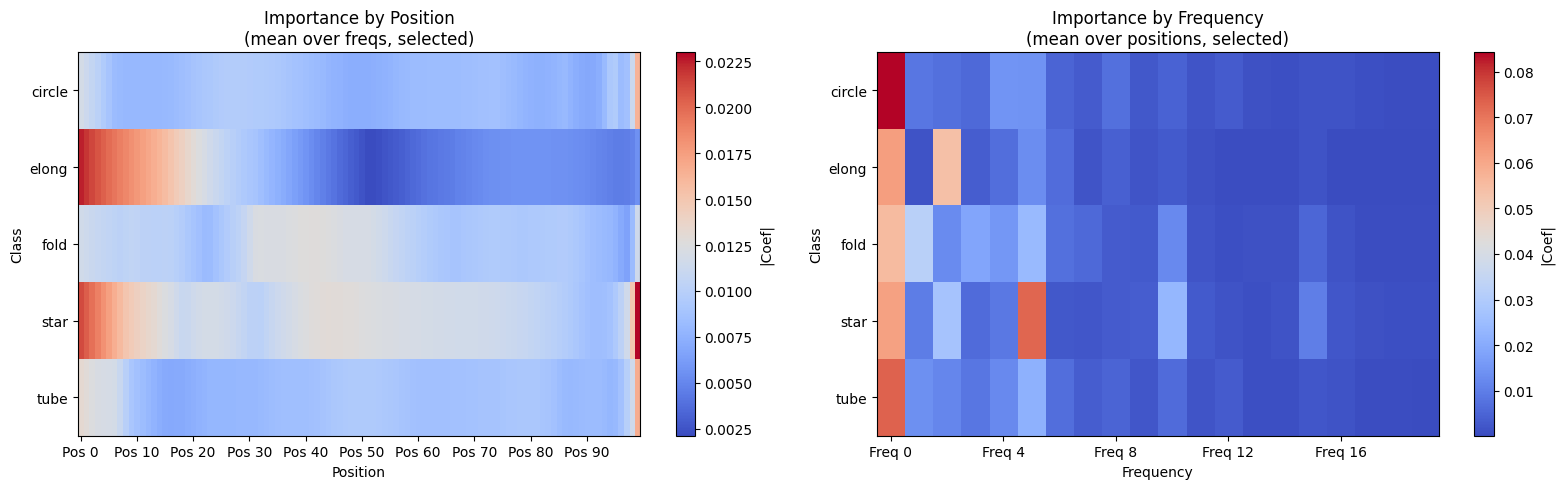

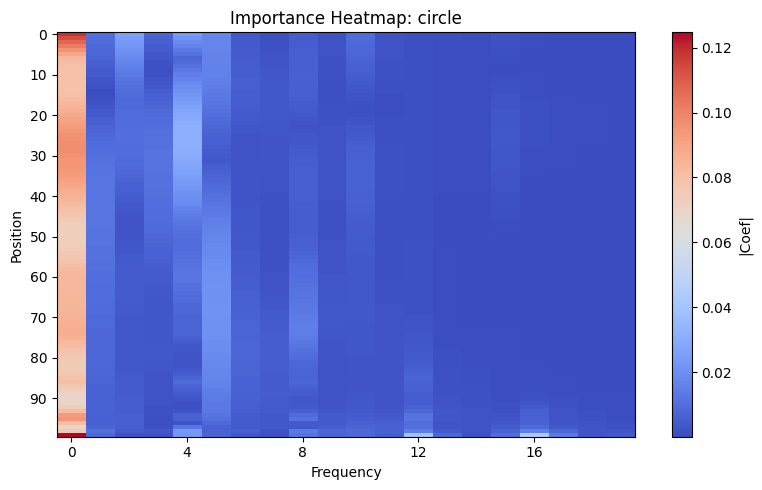

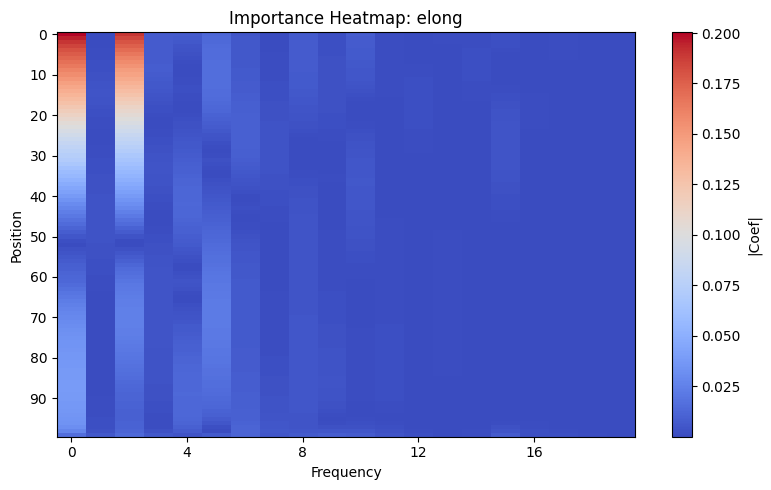

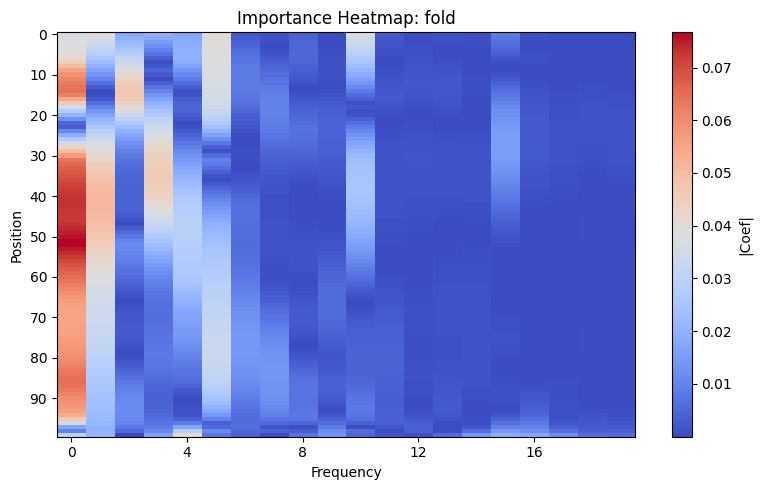

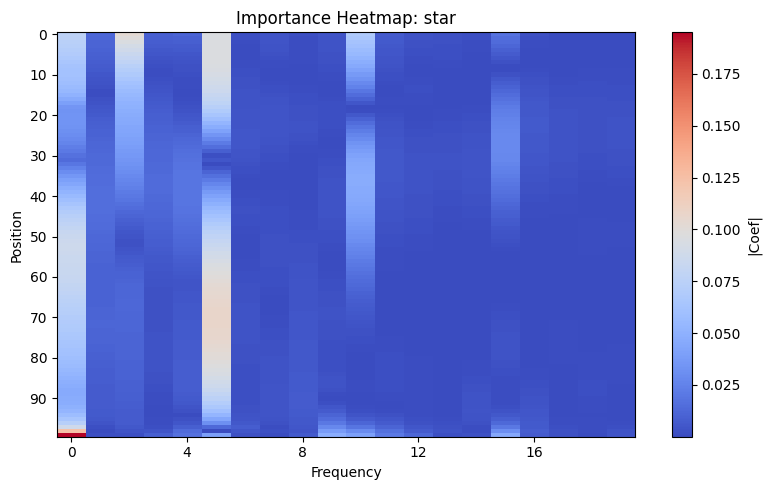

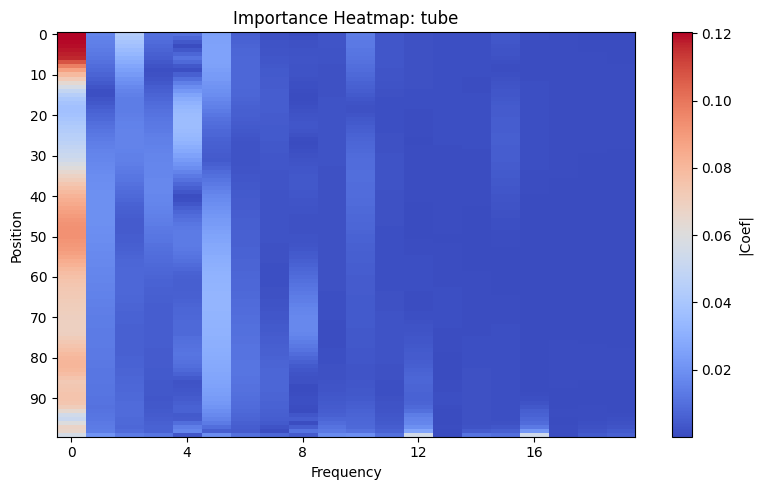

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# PARAMETERS: set how many freqs/positions to exclude from start/end
n_positions = 100
n_freqs     = 20
remove_first_freqs = 0
remove_last_freqs  = 0
remove_first_pos   = 0
remove_last_pos    = 0

# Prepare reduced features
X_reduced = X.reshape(-1, n_positions, n_freqs)
X_reduced = X_reduced[
    :,
    remove_first_pos : n_positions-remove_last_pos,
    remove_first_freqs : n_freqs-remove_last_freqs
]
X_reduced = X_reduced.reshape(X.shape[0], -1)  # flatten back

# Split (same random seed)
Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(
    X_reduced, y, stratify=y, random_state=42, test_size=0.75
)

# Retrain
clf_r = LogisticRegression(
    multi_class='multinomial',
    solver='newton-cg',
    tol=1e-6,
    max_iter=100,
    verbose=1,
    n_jobs=-1
).fit(Xtr_r, ytr_r)

print("Test accuracy (with specified removals):", clf_r.score(Xte_r, yte_r))

# Parameters for the reduced data
classes = le.classes_
n_classes = len(classes)
n_positions_r = n_positions - remove_first_pos - remove_last_pos
n_freqs_r     = n_freqs     - remove_first_freqs - remove_last_freqs

# Reshape coefficients
coefs_r = clf_r.coef_.reshape(n_classes, n_positions_r, n_freqs_r)

# --- PLOTS ---
# mean abs‐coef across freqs -> importance per position
pos_importance_r = np.abs(coefs_r).mean(axis=2)

# mean abs‐coef across positions -> importance per frequency
freq_importance_r = np.abs(coefs_r).mean(axis=1)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))

# — heatmap by position —
im0 = ax0.imshow(pos_importance_r, aspect='auto', cmap='coolwarm')
ax0.set_title("Importance by Position\n(mean over freqs, selected)")
ax0.set_ylabel("Class")
ax0.set_xlabel("Position")
ax0.set_yticks(np.arange(n_classes))
ax0.set_yticklabels(classes)
xticks = np.arange(0, n_positions_r, max(1, n_positions_r // 10))
ax0.set_xticks(xticks)
ax0.set_xticklabels([
    f"Pos {i+remove_first_pos}" for i in xticks
])
fig.colorbar(im0, ax=ax0, label="|Coef|")

# — heatmap by frequency —
im1 = ax1.imshow(freq_importance_r, aspect='auto', cmap='coolwarm')
ax1.set_title("Importance by Frequency\n(mean over positions, selected)")
ax1.set_ylabel("Class")
ax1.set_xlabel("Frequency")
ax1.set_yticks(np.arange(n_classes))
ax1.set_yticklabels(classes)
xticks_freq = np.arange(0, n_freqs_r, max(1, n_freqs_r // 5))
ax1.set_xticks(xticks_freq)
ax1.set_xticklabels([
    f"Freq {i+remove_first_freqs}" for i in xticks_freq
])
fig.colorbar(im1, ax=ax1, label="|Coef|")

plt.tight_layout()
plt.show()

# --- PER-CLASS FREQUENCY x POSITION IMPORTANCE ---
for i, cls in enumerate(classes):
    plt.figure(figsize=(8, 5))
    plt.imshow(
        np.abs(coefs_r[i]),
        aspect='auto',
        cmap='coolwarm'
    )
    plt.title(f"Importance Heatmap: {cls}")
    plt.ylabel("Position")
    plt.xlabel("Frequency")
    plt.yticks(
        np.arange(0, n_positions_r, max(1, n_positions_r // 10)),
        [f"{j+remove_first_pos}" for j in np.arange(0, n_positions_r, max(1, n_positions_r // 10))]
    )
    plt.xticks(
        np.arange(0, n_freqs_r, max(1, n_freqs_r // 5)),
        [f"{j+remove_first_freqs}" for j in np.arange(0, n_freqs_r, max(1, n_freqs_r // 5))]
    )
    plt.colorbar(label="|Coef|")
    plt.tight_layout()
    plt.show()


##  [From scratch optimal](https://github.com/RixonC/NewtonCG/blob/master/newton_cg.py)

In [ ]:
import numpy as np
import torch


def _cg(A, b, rtol, maxit, M_inv=None):
    """The conjugate gradient method to approximately solve ``Ax = b`` for
    ``x``, when ``A`` is symmetric and positive-definite.

    Args:
        A (callable): given vector ``x``, returns matrix-vector product ``Ax``.
            Assumes input and output of ``A`` are each stored as a flat
            ``Tensor``, for performance. Matrix must be symmetric and
            positive-definite.
        b (torch.Tensor): vector ``b`` in ``Ax = b``. Assumes ``b`` is stored as
            a flat ``Tensor``, for performance.
        rtol (float): termination tolerance for relative residual.
        maxit (int): maximum iterations.
        M_inv (callable, optional): given vector ``v``, return the inverse of
            ``M`` times ``v``, when ``M`` is a preconditioner. Assumes input
            and output of ``M_inv`` are each stored as a flat ``Tensor``, for
            performance. Defaults to ``None``.
    """
    if rtol < 0.0:
        raise ValueError("Invalid termination tolerance: {}."
                         " It must be non-negative.".format(rtol))
    if maxit < 0:
        raise ValueError("Invalid maximum iterations: {}."
                         " It must be non-negative.".format(maxit))

    n = len(b)
    device = b.device
    iters = 0
    x = torch.zeros(n, device=device)
    bb = torch.dot(b,b).item()
    if bb == 0:
        return x
    r = b.clone()
    if M_inv is None:
        z = r
        assert(id(z) == id(r))
    else:
        z = M_inv(r)
    p = z.clone()
    rz_old = torch.dot(r,z).item()

    while iters < maxit:
        iters += 1
        Ap = A(p)
        pAp = torch.dot(p,Ap).item()
        assert pAp > 0, "A is not positive-definite."
        alpha = rz_old / pAp
        x.add_(p, alpha=alpha)
        r.sub_(Ap, alpha=alpha)
        rr = torch.dot(r,r).item()
        if np.sqrt(rr/bb) <= rtol:
            break
        if M_inv is None:
            assert(id(z) == id(r))
            rz_new = rr
        else:
            z = M_inv(r)
            rz_new = torch.dot(r,z).item()
        beta = rz_new/rz_old
        p.mul_(beta).add_(z)
        rz_old = rz_new

    return x


class NewtonCG(torch.optim.Optimizer):
    """Implements Newton-CG algorithm with backtracking line-search. CG refers
    to the conjugate gradient method, which is the sub-problem solver.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups.
        lr (float, optional): learning rate, if ``line_search_max_iter = 0``.
            Otherwise, initial step-size tried in line-search. Defaults to
            ``1``.
        cg_tol (float, optional): termination tolerance for relative
            residual in CG. Defaults to ``1e-4``.
        cg_max_iter (int, optional): maximum CG iterations. Defaults to ``10``.
        line_search_max_iter (int, optional): maximum line-search iterations.
            Defaults to ``100``.
        line_search_param (float, optional): backtracking line-search parameter.
            Defaults to ``1e-4``.
    """
    def __init__(self, params, lr=1, cg_tol=1e-4, cg_max_iter=10,
                 line_search_max_iter=100, line_search_param=1e-4):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}."
                             " It must be non-negative.".format(lr))
        if cg_tol < 0.0:
            raise ValueError("Invalid termination tolerance for CG: {}."
                             " It must be non-negative.".format(cg_tol))
        if cg_max_iter < 0:
            raise ValueError("Invalid maximum CG iterations: {}"
                             ". It must be non-negative.".format(cg_max_iter))
        if line_search_max_iter < 0:
            raise ValueError("Invalid maximum line-search iterations: {}."
                             " It must be non-negative.".format(
                                line_search_max_iter))
        if line_search_param < 0.0:
            raise ValueError("Invalid backtracking line-search parameter: {}."
                             " It must be non-negative.".format(
                                line_search_param))
        defaults = dict(lr=lr, cg_tol=cg_tol, cg_max_iter=cg_max_iter,
                        line_search_max_iter=line_search_max_iter,
                        line_search_param=line_search_param)
        super(NewtonCG, self).__init__(params, defaults)
        if len(self.param_groups) != 1:
            raise ValueError("NewtonCG doesn't support per-parameter options "
                             "(parameter groups)")
        self._params = self.param_groups[0]['params']

    def _get_flat_grad(self):
        """Return stored gradients from parameters, as a flat ``Tensor``."""
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                view = p.grad.to_dense().reshape(-1)
            else:
                view = p.grad.reshape(-1)
            views.append(view)
        return torch.cat(views, 0)

    def _get_flat_hess_vect(self, vect, closure):
        """Return Hessian-vector product, as a flat ``Tensor``.

        Args:
            vect (torch.Tensor): vector used in Hessian-vector product, as a
                flat ``Tensor``.
            closure (callable): a closure that reevaluates the model and returns
                the loss.
        """
        with torch.enable_grad():
            loss = closure()
            assert loss.requires_grad == True
            for p in self._params: # zero gradients
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()
            loss.backward(create_graph=True)
            tmp_flat_grad = self._get_flat_grad()
            for p in self._params: # zero gradients
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()
            dot_prod = torch.dot(tmp_flat_grad, vect)
            dot_prod.backward()
        return self._get_flat_grad()

    def _get_flat_hess_inv_vect(self, vect, cg_tol, cg_max_iter, closure):
        """Return approximate solution, as a flat ``Tensor``, to Newton method's
        sub-problem using CG.

        Args:
            vect (torch.Tensor): vector in sub-problem, as a flat ``Tensor``.
            cg_tol (float): termination tolerance for relative residual in CG.
            cg_max_iter (int): maximum CG iterations.
            closure (callable): a closure that reevaluates the model and returns
                the loss.
        """
        hess_vect = lambda v : self._get_flat_hess_vect(v, closure)
        return _cg(hess_vect, vect, cg_tol, cg_max_iter)

    def _get_update_direction(self, flat_grad, cg_tol, cg_max_iter, closure):
        """Return Newton method's update direction, as a flat ``Tensor``.

        Args:
            flat_grad (torch.Tensor): the gradient, as a flat ``Tensor``.
            cg_tol (float): termination tolerance for relative residual in CG.
            cg_max_iter (int): maximum CG iterations.
            closure (callable): a closure that reevaluates the model and returns
                the loss.
        """
        return -self._get_flat_hess_inv_vect(flat_grad, cg_tol, cg_max_iter,
                                             closure)

    def _line_search(self, current_loss, current_flat_grad, update_direction,
                     init_step_size, line_search_max_iter, line_search_param,
                     closure):
        """Perform backtracking line-search on the loss.

        Args:
            current_loss (float): the current loss.
            current_flat_grad (torch.Tensor): the current gradient, as a flat
                ``Tensor``.
            update_direction (torch.Tensor): update direction, as a flat
                ``Tensor``.
            init_step_size (float): initial step-size to try.
            line_search_max_iter (int): maximum line-search iterations.
            line_search_param (float): backtracking line-search parameter.
            closure (callable): a closure that reevaluates the model and returns
                the loss.
        """
        step_size = init_step_size
        ls_iter = 0
        while ls_iter < line_search_max_iter:
            directional_derivative = torch.dot(
                current_flat_grad, update_direction)
            condition = (current_loss
                + step_size * line_search_param * directional_derivative)
            new_loss = self._directional_evaluate(
                update_direction, step_size, closure)
            if new_loss <= condition:
                break
            step_size *= 0.5
            ls_iter += 1
        return step_size, ls_iter

    def _update_params(self, update_direction, step_size):
        """Update parameters given an update direction and step-size.

        Args:
            update_direction (torch.Tensor): update direction, as a flat
                ``Tensor``.
            step_size (float): step-size.
        """
        offset = 0
        for p in self._params:
            numel = p.numel()
            p.add_(update_direction[offset:offset+numel].reshape_as(p),
                alpha=step_size)
            offset += numel

    def _directional_evaluate(self, update_direction, step_size, closure):
        """Return the loss after the parameters are updated given an update
        direction and step-size. Changes made to the parameters, for this
        evaluation, are undone after this evaluation.

        Args:
            update_direction (torch.Tensor): update direction, as a flat
                ``Tensor``.
            step_size (float): step-size.
            closure (callable): a closure that reevaluates the model and returns
                the loss.
        """
        self._update_params(update_direction, step_size)
        ret = closure()
        self._update_params(update_direction, -step_size)
        return ret

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Args:
            closure (callable): A closure that reevaluates the model and returns
                the loss.
        """
        assert len(self.param_groups) == 1
        closure = torch.enable_grad()(closure)

        lr = self.param_groups[0]['lr']
        cg_tol = self.param_groups[0]['cg_tol']
        cg_max_iter = self.param_groups[0]['cg_max_iter']
        line_search_max_iter = self.param_groups[0]['line_search_max_iter']
        line_search_param = self.param_groups[0]['line_search_param']

        loss = closure()
        flat_grad = self._get_flat_grad()
        update_direction = self._get_update_direction(
            flat_grad, cg_tol, cg_max_iter, closure)
        step_size, ls_iter = self._line_search(
            loss, flat_grad, update_direction, lr, line_search_max_iter,
            line_search_param, closure)
        self._update_params(update_direction, step_size)

        return loss

In [ ]:

from sklearn.preprocessing import StandardScaler
import torch, time, numpy as np
import torch.nn.functional as F           # for the bias trick

scaler = StandardScaler(with_mean=True)
Xtr_std = scaler.fit_transform(Xtr)       # fit on train only
Xte_std = scaler.transform(Xte)

device   = "cuda" if torch.cuda.is_available() else "cpu"

Xtr_t = torch.from_numpy(Xtr_std).float().to(device)    # (Ntr, 2000)
Xte_t = torch.from_numpy(Xte_std).float().to(device)    # (Nte, 2000)
ytr_t = torch.from_numpy(ytr).long().to(device)         # (Ntr,)
yte_t = torch.from_numpy(yte).long().to(device)         # (Nte,)

n_features = Xtr_t.shape[1]
n_classes  = len(np.unique(y))

weights_t = torch.zeros(n_features, n_classes,
                        device=device, requires_grad=True)
bias_t    = torch.zeros(n_classes,
                        device=device, requires_grad=True)

def logits_fn(X):
    """Linear logits N×K (same as nn.Linear)"""
    return X.mm(weights_t) + bias_t

criterion = torch.nn.CrossEntropyLoss()
lam       = 1e-4                            # tiny ridge keeps Hessian PD

optimizer = NewtonCG([weights_t, bias_t],   # iterable of parameters
                     lr=1.0,
                     cg_tol=1e-4, cg_max_iter=10,
                     line_search_max_iter=25, line_search_param=1e-4)


num_epochs = 30
t0 = time.time()

for epoch in range(num_epochs):

    # ----- test accuracy ------------------------------------
    with torch.no_grad():
        preds_te = logits_fn(Xte_t).argmax(dim=1)
        acc_te   = (preds_te == yte_t).float().mean().item() * 100.0

    # ----- Newton–CG step -----------------------------------
    optimizer.zero_grad()                   # clear previous grads
    loss = criterion(logits_fn(Xtr_t), ytr_t) \
         + 0.5 * lam * (weights_t.pow(2).sum() + bias_t.pow(2).sum())
    loss.backward()                         # gradient ONCE for CG
    closure = lambda : (
        criterion(logits_fn(Xtr_t), ytr_t)
        + 0.5 * lam * (weights_t.pow(2).sum() + bias_t.pow(2).sum())
    )
    loss_val = optimizer.step(closure).item()

    print(f"epoch: {epoch:02d},  loss: {loss_val:8.2e},  "
          f"test accuracy: {acc_te:5.2f}")

print(f"\nFinished in {time.time()-t0:4.2f} s on {device.upper()}")


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /pytorch/torch/csrc/autograd/engine.cpp:1260.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 00,  loss: 1.61e+00,  test accuracy: 20.00
epoch: 01,  loss: 2.66e-02,  test accuracy: 100.00
epoch: 02,  loss: 9.64e-03,  test accuracy: 100.00
epoch: 03,  loss: 3.54e-03,  test accuracy: 100.00
epoch: 04,  loss: 1.31e-03,  test accuracy: 100.00
epoch: 05,  loss: 5.00e-04,  test accuracy: 100.00
epoch: 06,  loss: 2.07e-04,  test accuracy: 100.00
epoch: 07,  loss: 1.01e-04,  test accuracy: 100.00
epoch: 08,  loss: 6.55e-05,  test accuracy: 100.00
epoch: 09,  loss: 5.36e-05,  test accuracy: 100.00
epoch: 10,  loss: 5.00e-05,  test accuracy: 100.00
epoch: 11,  loss: 4.91e-05,  test accuracy: 100.00
epoch: 12,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 13,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 14,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 15,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 16,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 17,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 18,  loss: 4.89e-05,  test accuracy: 100.00
epoch: 19,  loss: 4.89e-05,  tes

## Generalized functional linear model
[B-Spline](https://fda.readthedocs.io/en/stable/modules/autosummary/skfda.representation.basis.BSplineBasis.html)

## Chebyshev × Fourier Vandermonde Matrix

The design matrix **V** has shape `(N, (n+1) * (2·N_f + 1))`, where:
- **N** is the number of samples (length of `r` and `φ` arrays).
- **n+1** is the number of Chebyshev polynomials $T_0, T_1, \dots, T_n$.
- **2·N_f + 1** accounts for the constant term $m=0$ and the sine/cosine pairs for frequencies $m=1,\dots,N_f$.

Each row of **V** corresponds to one sample $(r_i,φ_i)$, and each column is one basis function:
1. $T_j(r_i)$ for $j=0$ (constant Chebyshev term)  
2. $T_j(r_i)\,\cos(m\,φ_i)$ and $T_j(r_i)\,\sin(m\,φ_i)$ for $m=1,\dots,N_f$, repeated for each Chebyshev degree $j=0,\dots,n$.

This matrix allows projecting radial–angular data onto a combined Chebyshev–Fourier basis


In [5]:
import numpy as np

def Vand_matrix(r: np.ndarray,
                phi: np.ndarray,
                n: int,
                N_f: int) -> np.ndarray:
    """
    Build a real Chebyshev × Fourier (cos/sin) Vandermonde-like design matrix.

    Parameters
    ----------
    r   : 1-D array of radii (N,)
    phi : 1-D array of angles (radians) (N,) -- same shape as r
    n   : highest Chebyshev degree  (includes T_0 .. T_n)
    N_f : highest angular frequency (m = 0 .. N_f)

    Returns
    -------
    V : 2-D array of shape (N, (n+1)*(2*N_f+1))
        Column ordering (within each Chebyshev degree j):
            m=0:        T_j(r) * cos(0 φ)
            m>=1:       T_j(r) * cos(m φ), T_j(r) * sin(m φ)
        Then repeats for j = 0..n.
    """
    if r.shape != phi.shape:
        raise ValueError("r and phi must have the same shape")

    N = r.size
    n_cheb = n + 1
    n_four_cols = 2 * N_f + 1              # 1 (m=0) + 2 columns per m>=1
    # 3D buffer: (cheb_degree, fourier_component, sample)
    B = np.zeros((n_cheb, n_four_cols, N), dtype=float)

    # Precompute Chebyshev values T_j(r)
    T_vals = [np.polynomial.Chebyshev.basis(j)(r) for j in range(n_cheb)]

    # m = 0 (cos 0φ = 1)
    for j in range(n_cheb):
        B[j, 0, :] = T_vals[j]

    # m >= 1
    for m in range(1, N_f + 1):
        cos_m = np.cos(m * phi)
        sin_m = np.sin(m * phi)
        cos_idx = 1 + 2 * (m - 1)
        sin_idx = cos_idx + 1
        for j in range(n_cheb):
            Tj = T_vals[j]
            B[j, cos_idx, :] = Tj * cos_m
            B[j, sin_idx, :] = Tj * sin_m

    # Reshape to (N, features)
    V = B.reshape(n_cheb * n_four_cols, N).T
    return V

## Functional Vandermonde Features & Logistic Regression

We build a combined Chebyshev–Fourier feature matrix as follows:

1. **Flatten polar grid**  
   - Define radial and angular samples  
     $r_i \in [0,1],\quad \phi_i\in[0,2\pi),\quad i=1,\dots,N,\quad N = n_{\rm radii}\times n_{\rm angles}.$  
   - Flatten into two vectors  
     $\mathbf r = (r_1,\dots,r_N),\quad \boldsymbol\phi=(\phi_1,\dots,\phi_N).$

2. **Construct Vandermonde matrix**  
   We include Chebyshev polynomials $T_j(r)$ of degree $j=0,\dots,n_{\rm cheb}$ and Fourier terms for $m=0,\dots,N_f$.  Each row $i$ and column indexed by $(j,m)$ is  
   $$
   V_{i,(j,m)} =
   \begin{cases}
     T_j(r_i), & m=0,\\
     T_j(r_i)\,\cos(m\,\phi_i), & m=1,\dots,N_f,\\
     T_j(r_i)\,\sin(m\,\phi_i), & m=-1,\dots,-N_f.
   \end{cases}
   $$  
   Thus  
   $$
   V\in\mathbb R^{\,N\times\bigl((n_{\rm cheb}+1)\,(2N_f+1)\bigr)}.
   $$

3. **Regularized pseudo-inverse**  
   We compute  
   $$
   V^+ = (V^\top V + \lambda I)^{-1} V^\top,
   $$  

4. **Feature extraction**  
   Vectorize each object’s coefficients $Y_i=\mathrm{vec}(\mathrm{coef}[i])\in\mathbb R^N$ and project:  
   $$
   X_i = V^+ Y_i,
   $$  
   yielding feature matrix $X\in\mathbb R^{n_{\rm objects}\times n_{\rm features}}$.

6. **Multinomial logistic regression**  
   Fit  
   $$
   \hat y = \arg\max_c \;\sigma(W X + b)_c
   $$  
   with solver “newton-cg” and $L_2$ penalty.  Evaluate train/test accuracy and plot the confusion matrix.

7. **Reshape coefficients back**  
   The learned weight matrix $W\in\mathbb R^{n_{\rm classes}\times n_{\rm features}}$ is transposed and reshaped:  
   $$
   \beta\in\mathbb R^{(n_{\rm cheb}+1)\times(2N_f+1)\times n_{\rm classes}},
   $$  
   so that $\beta_{j,m,c}$ gives the Chebyshev–Fourier weight for class $c$.

8. **Reconstruction**  
   For class $c$, reconstruct on the original grid:  
   $$
   \widehat f_c(r_i,\phi_i)
   = \sum_{j=0}^{n_{\rm cheb}}
     \Bigl[
       \beta_{j,0,c}T_j(r_i)
       + \sum_{m=1}^{N_f}\bigl(\beta_{j,m,c}T_j(r_i)\cos m\phi_i
       + \beta_{j,-m,c}T_j(r_i)\sin m\phi_i\bigr)
     \Bigr].
   $$  
   Reshape back to $(n_{\rm radii},n_{\rm angles})$ for visualization.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


train acc  discrete=1.000 | functional=1.000
test  acc  discrete=1.000 | functional=1.000


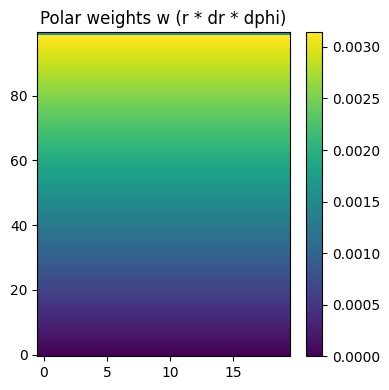

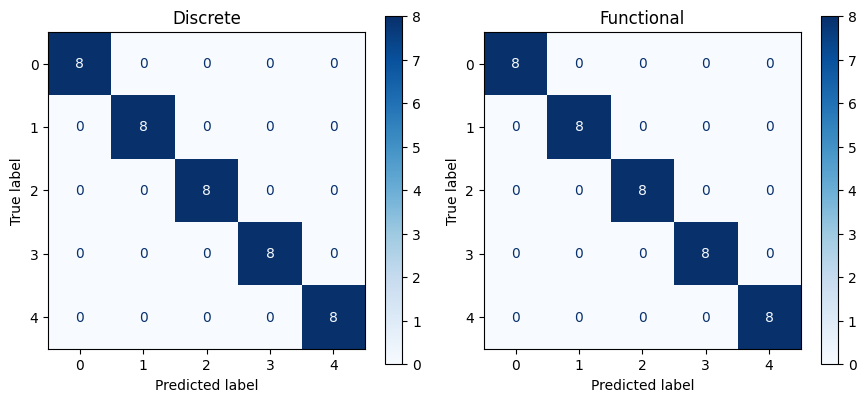

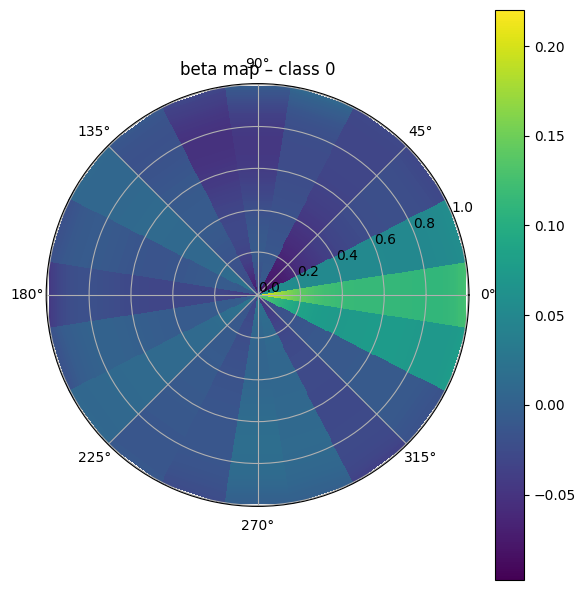

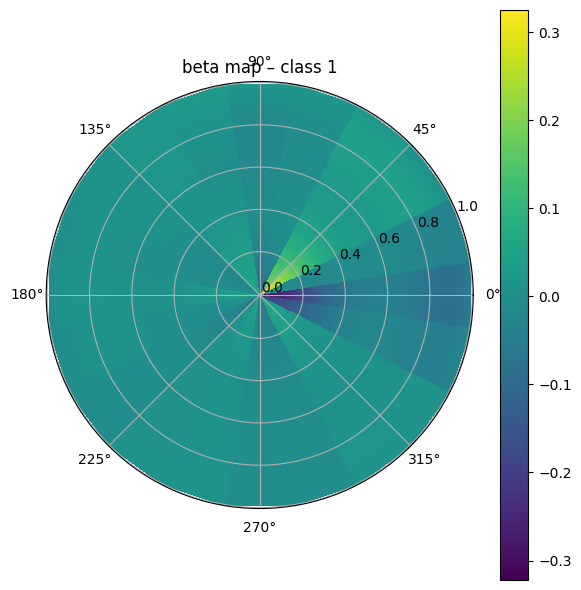

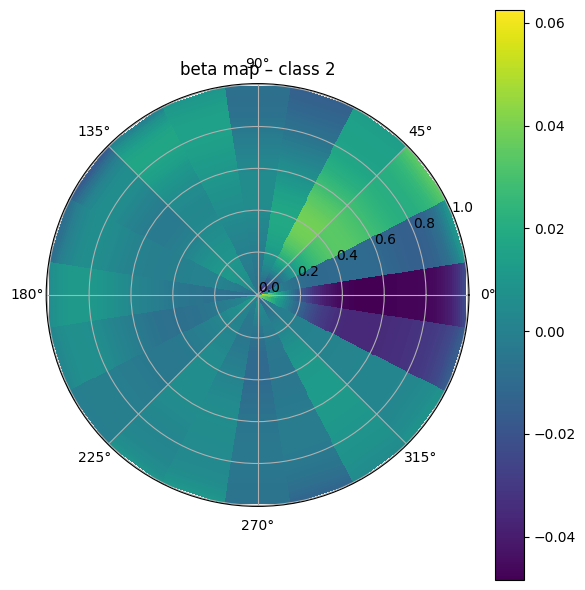

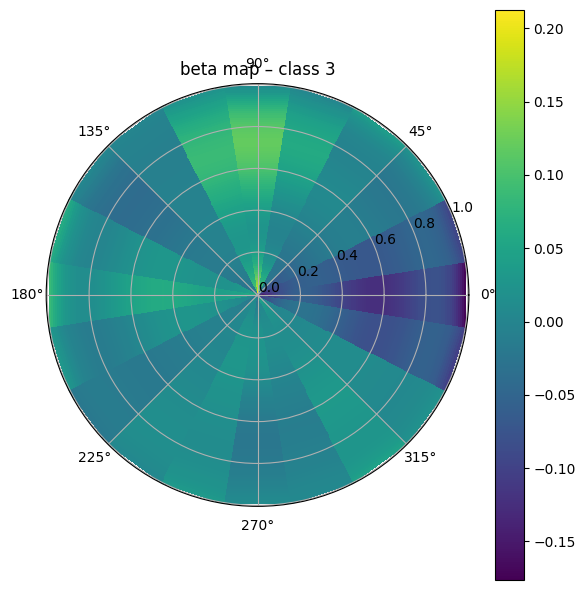

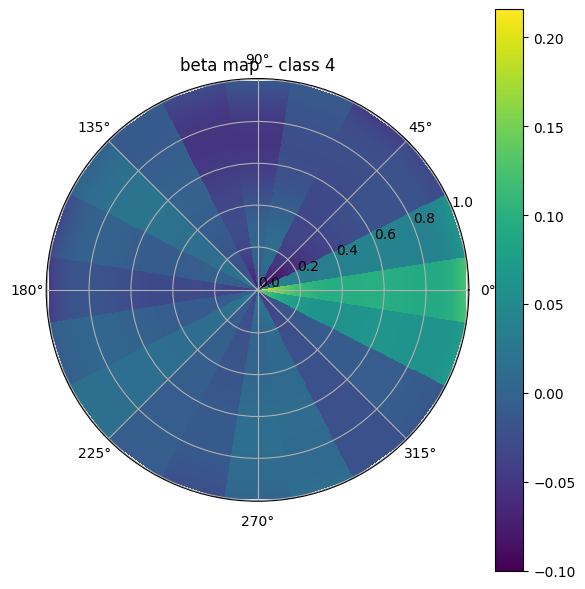

In [34]:
"""
Discrete vs Functional
----------------------
* Discrete:  inv(V.T @ V + lam*I)      @ V.T        y
* Functional: inv(V.T @ W @ V + lam*I) @ V.T @ W    y
"""

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- grid ------------------------------------------------------------------
n_objects, n_radii, n_angles = coef.shape
r   = np.linspace(0.0, 1.0, n_radii)
phi = np.linspace(0.0, 2.0*np.pi, n_angles, endpoint=False)
R, PHI = np.meshgrid(r, phi, indexing="ij")        # (n_radii, n_angles)

#  Vandermonde (Chebyshev x Fourier)
n_cheb, n_fourier = 5, 5
V = Vand_matrix(R.ravel(), PHI.ravel(), n_cheb, n_fourier)  # (N, p)
p = V.shape[1]

#  trapezoidal weights (polar)
dr          = r[1] - r[0]
r_w         = r * dr
r_w[[0, -1]] *= 0.5
phi_w       = (2.0*np.pi / n_angles) * np.ones(n_angles)
w           = np.repeat(r_w, n_angles) * np.tile(phi_w, n_radii)
W           = np.diag(w)

#  pseudo‑inverses
lam = 1e-6
A_d = V.T @ V + lam*np.eye(p)
A_f = V.T @ W @ V + lam*np.eye(p)
V_pinv = np.linalg.solve(A_d, V.T)
V_Winv = np.linalg.solve(A_f, V.T @ W)

#  feature matrices
X_d = np.empty((n_objects, p))
X_f = np.empty_like(X_d)

for i, y_i in enumerate(coef.reshape(n_objects, -1)):
    X_d[i] = V_pinv @ y_i
    X_f[i] = V_Winv @ y_i

#  train/test split
Xd_tr, Xd_te, y_tr, y_te = train_test_split(
    X_d, y, test_size=0.8, stratify=y, random_state=42
)
Xf_tr, Xf_te, _, _ = train_test_split(
    X_f, y, test_size=0.8, stratify=y, random_state=42
)

#  multinomial GLM
clf_d = LogisticRegression(
    multi_class="multinomial", solver="newton-cg",
    penalty="l2", C=1.0, max_iter=1000
).fit(Xd_tr, y_tr)

clf_f = LogisticRegression(
    multi_class="multinomial", solver="newton-cg",
    penalty="l2", C=1.0, max_iter=1000
).fit(Xf_tr, y_tr)

print(
    f"train acc  discrete={accuracy_score(y_tr, clf_d.predict(Xd_tr)):.3f} | "
    f"functional={accuracy_score(y_tr, clf_f.predict(Xf_tr)):.3f}"
)
print(
    f"test  acc  discrete={accuracy_score(y_te, clf_d.predict(Xd_te)):.3f} | "
    f"functional={accuracy_score(y_te, clf_f.predict(Xf_te)):.3f}"
)


# weight map (w)
plt.figure(figsize=(4, 4))
plt.imshow(w.reshape(n_radii, n_angles), origin="lower", aspect="auto")
plt.title("Polar weights w (r * dr * dphi)")
plt.colorbar(); plt.tight_layout(); plt.show()


# confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay.from_predictions(
    y_te, clf_d.predict(Xd_te), ax=ax[0], cmap="Blues"
)
ax[0].set_title("Discrete")
ConfusionMatrixDisplay.from_predictions(
    y_te, clf_f.predict(Xf_te), ax=ax[1], cmap="Blues"
)
ax[1].set_title("Functional")
plt.tight_layout(); plt.show()


# beta(r,phi) for class 0
beta_flat = clf_f.coef_.T                                   # (p, n_classes)
beta_hat = beta_flat.reshape(
    (n_cheb + 1, 2 * n_fourier + 1, beta_flat.shape[1]),
    order="F"
)

for class_idx in range(5):
  theta_vec = beta_hat[..., class_idx].reshape(-1, order="F")
  recon_grid = (V @ theta_vec).reshape(n_radii, n_angles, order="C")

  plt.figure(figsize=(6, 6))
  ax = plt.subplot(111, projection="polar")
  pc = ax.pcolormesh(phi, r, recon_grid, shading="auto")
  ax.set_title(f"beta map – class {class_idx}")
  plt.colorbar(pc, ax=ax)
  plt.tight_layout(); plt.show()


relative L2‑error (functional)  = 0.8028


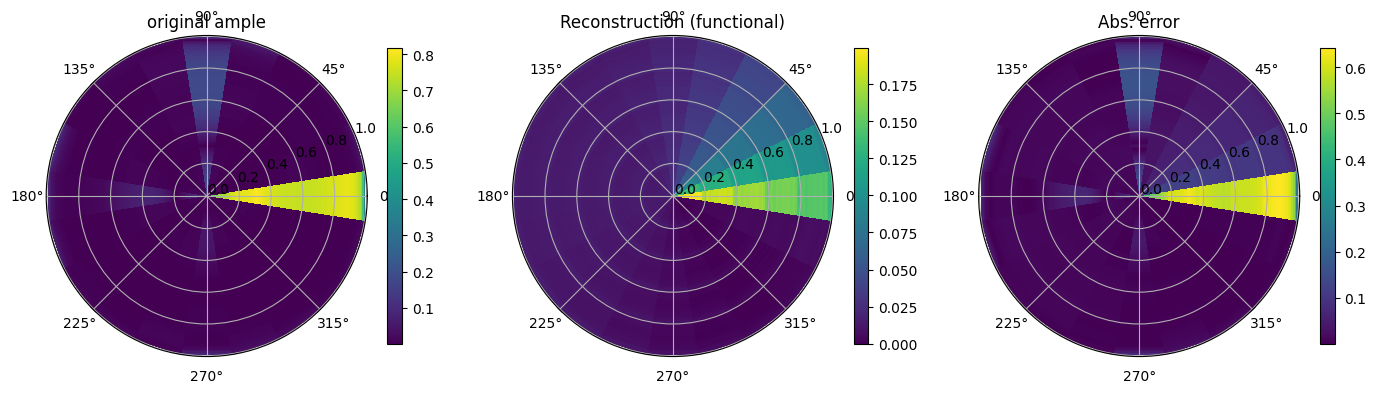

In [35]:
obj_idx = Xf_te.index[17] if hasattr(Xf_te, "index") else 0
y_vec   = coef[obj_idx].ravel(order="F")
theta_f = V_Winv @ y_vec
y_hat   = V @ theta_f

rel_l2  = np.linalg.norm(y_vec - y_hat) / np.linalg.norm(y_vec)
print(f"relative L2‑error (functional)  = {rel_l2:.4f}")

orig   = y_vec.reshape(n_radii, n_angles, order="F")
recon  = y_hat.reshape(n_radii, n_angles, order="F")
diff   = np.abs(orig - recon)

#  polar heatmap
titles = ["original ample", "Reconstruction (functional)", "Abs. error"]
data   = [orig, recon, diff]

fig, ax = plt.subplots(1, 3, figsize=(14, 4),
                       subplot_kw={"projection": "polar"})
for a, d, t in zip(ax, data, titles):
    pcm = a.pcolormesh(phi, r, d, shading="auto")
    a.set_title(t)
    plt.colorbar(pcm, ax=a, shrink=0.8)
plt.tight_layout(); plt.show()
